In [1]:
###############################################
suppressPackageStartupMessages(require(tidyverse))
suppressPackageStartupMessages(require(data.table))


### Step 1. Read the relevant data

In [4]:
lab_repo_dir <- '/oak/stanford/groups/mrivas/users/ytanigaw/repos/rivas-lab'
pheno <- 'Testosterone'

score_files <- list()

score_files[['male']] <- file.path(
    lab_repo_dir, 'sex-div-analysis/snpnet/out', 'onesex',  
    pheno, 'results/score', paste0(pheno, '.sscore')
)

score_files[['female']] <- file.path(
    lab_repo_dir, 'sex-div-analysis/snpnet/out', 'zerosex', 
    pheno, 'results/score', paste0(pheno, '.sscore')
)

score_files[['pre_meno']] <- file.path(
    lab_repo_dir, 'sex-div-analysis/snpnet/out', 'pre_meno',
    pheno, 'results/score', paste0(pheno, '.sscore')
)

score_files[['post_meno']] <- file.path(
    lab_repo_dir, 'sex-div-analysis/snpnet/out', 'post_meno', 
    pheno, 'results/score', paste0(pheno, '.sscore')
)

score_files[['combined']] <- file.path(
    lab_repo_dir, 'public-resources/uk_biobank/biomarkers/snpnet/data',
    pheno, 'results/score', paste0(pheno, '.sscore')
)


In [5]:
score_df <- bind_rows(lapply(
    names(score_files), function(x){    
        fread(score_files[[x]], sep='\t') %>% 
        rename('FID' = '#FID') %>% 
        select(FID, IID, SCORE1_SUM) %>%
        mutate(score_type = x)
    }
)) %>% spread(score_type, SCORE1_SUM)


In [7]:
t_med <- fread('/scratch/PI/mrivas/users/erflynn/sex_div_gwas/data/t_related.txt')

read_phe <- function(){
    phe_dir <- '/oak/stanford/groups/mrivas/projects/biomarkers/covariate_corrected'
    phe_suffix <- 'phenotypes/residual/Testosterone.phe'
    
    bind_rows(lapply(c(
        'outputExtendedBMIreducedMaleWhiteBritish',
        'outputExtendedBMIreducedFemaleWhiteBritish'
    ), function(x){
        fread(file.path(phe_dir, x, phe_suffix))%>%
        filter(! IID %in% (t_med %>% select(IID) %>% pull())) %>%
        drop_na()
    }))
}


In [8]:
read_keep <- function(name){
    keep_dir <- '/scratch/PI/mrivas/users/erflynn/sex_div_gwas/phefiles'
    df <- fread(file.path(keep_dir, paste0(name, '.keep')))
    colnames(df) <- c('FID')
    df %>% mutate(IID = FID, keep = name)
}


In [9]:
sex_stratified_phe <- read_phe()


In [10]:
keep_df <- bind_rows(lapply(c('onesex', 'zerosex', 'pre_meno', 'post_meno'), function(x){
    read_keep(x) %>% 
    inner_join(sex_stratified_phe, by=c('FID', 'IID'))
}))


combined_phe <- fread(file.path(
    lab_repo_dir, 
    'public-resources/uk_biobank/biomarkers/snpnet/data/biomarkers_covar.phe'
))


split_df <- bind_rows(lapply(c('train', 'val', 'test'), function(x){
    df <- fread(file.path(
        '/scratch/users/ytanigaw/tmp/snpnet/geno/array_combined',
        paste0(x, '.fam')
    )) %>% mutate(keep = x)
    df %>% select(V1, V2, keep) %>% 
    rename('FID' = 'V1', 'IID' = 'V2')
}))


In [11]:
all_df <- keep_df %>%
rename('phe' = 'Testosterone') %>%
left_join(
    combined_phe %>% 
    select(FID, IID, sex, Testosterone) %>%
    rename('phe_combined' = 'Testosterone'),
    by=c('FID', 'IID')
) %>% 
left_join(
    split_df %>% rename('split' = 'keep'), by=c('FID', 'IID')
) %>% 
left_join(
    score_df, by=c('FID', 'IID')
) %>% drop_na()


In [12]:
all_df %>% count(keep, sex)

keep,sex,n
onesex,1,144108
post_meno,0,77154
pre_meno,0,32087
zerosex,0,142253


### Step 2. Compute statistics for the plots

In [13]:
compute_residual_predictions <- function(df, l_bin, u_bin, middle_df){
    stratified_df <- df %>% 
    filter(l_bin < Percentile, Percentile <= u_bin) %>%
    mutate(PRS_bin = T)

    glmfit <- glm (
        phe ~ as.factor(PRS_bin),
        bind_rows(middle_df, stratified_df),
        family='gaussian'
    )
    
    mean    <- summary(glmfit)$coefficients[2,1]
    std_e <- summary(glmfit)$coefficients[2,2]   
    l_err   <- mean - std_e
    u_err   <- mean + std_e
        
    data.frame(
        l_bin = l_bin,
        u_bin = u_bin,
        mean   = mean,
        std_err = std_e,
        l_err = l_err,
        u_err = u_err,
        mean_str = sprintf('%.3f (%.3f-%.3f)', mean, l_err, u_err)
    ) %>%
    mutate(mean_str = as.character(mean_str))
}

compute_summary_df <- function(df, PRS_type){
    middle_df <- df %>% 
    filter(0.4 < Percentile, Percentile <= 0.6) %>%
    mutate(PRS_bin = F)

    bind_rows(
        compute_residual_predictions(df,   0, .01, middle_df),
        compute_residual_predictions(df, .01, .05, middle_df),
        lapply(2:19, function(x){
            compute_residual_predictions(df, (x-1)/20, x/20, middle_df)
        }),
        compute_residual_predictions(df, .95, .99, middle_df),
        compute_residual_predictions(df, .99, 1, middle_df),
    )  %>%
    mutate(PRS_type = PRS_type)
}


In [14]:
all_df %>% count(split, sex, keep)

split,sex,keep,n
test,0,post_meno,15699
test,0,pre_meno,6362
test,0,zerosex,28640
test,1,onesex,28601
train,0,post_meno,53860
train,0,pre_meno,22635
train,0,zerosex,99564
train,1,onesex,100913
val,0,post_meno,7595
val,0,pre_meno,3090


### extract the test set and separate by sex


In [30]:
test_df <- all_df %>% filter(split == 'test') %>% select(-split) %>%
rename('PRS_combined' = 'combined')

test_male_df   <- test_df %>% filter(keep == 'onesex') %>% 
select(-sex, -keep, -female, -pre_meno, -post_meno)

test_female_df <- test_df %>% filter(keep == 'zerosex') %>% 
select(-sex, -keep, -male)


### split into different PRS models

In [31]:
test_male_combined_df <- test_male_df %>% select(FID, IID, phe_combined, PRS_combined) %>%
rename('phe' = 'phe_combined', 'PRS' = 'PRS_combined') %>% 
mutate(Percentile = rank(-PRS) / n())


In [33]:
test_male_sex_df <- test_male_df %>% 
rename('PRS' = 'male') %>%
select(FID, IID, phe, PRS) %>%
mutate(Percentile = rank(-PRS) / n())


In [35]:
test_female_df %>% head()

FID,IID,phe,phe_combined,PRS_combined,female,post_meno,pre_meno
1142584,1142584,-0.2592149,-0.3195730,0.1257300,0.178976,-0.00453349,-0.0576632
1325300,1325300,-0.3247268,-0.3046291,0.0871055,0.116813,0.04138580,-0.0638830
5410653,5410653,0.3390487,0.2314690,0.1375830,0.176485,0.04693420,0.0253178
5403487,5403487,0.3430886,0.2991584,0.2107460,0.351095,0.16790300,0.0523246
2986713,2986713,-0.2254421,-0.2311343,0.3181580,0.372013,0.13399100,0.0534096
5750428,5750428,0.3232317,0.3043602,0.1735580,0.384531,0.14761900,0.0565987


In [36]:
test_female_combined_df <- test_female_df %>% 
select(FID, IID, phe_combined, PRS_combined) %>%
rename('phe' = 'phe_combined', 'PRS' = 'PRS_combined') %>% 
mutate(Percentile = rank(-PRS) / n())


In [38]:
test_female_sex_df <- test_female_df %>% 
select(FID, IID, phe, female) %>%
rename('PRS' = 'female') %>%
mutate(Percentile = rank(-PRS) / n())


In [39]:
test_female_pre_meno_df <- test_female_df %>% 
select(FID, IID, phe, pre_meno) %>%
rename('PRS' = 'pre_meno') %>%
mutate(Percentile = rank(-PRS) / n())


In [40]:
test_female_post_meno_df <- test_female_df %>% 
select(FID, IID, phe, post_meno) %>%
rename('PRS' = 'post_meno') %>%
mutate(Percentile = rank(-PRS) / n())


In [46]:
summary_dfs <- list()

summary_dfs[['male_combined']]    <- test_male_combined_df %>%    compute_summary_df('combined')
summary_dfs[['male_sex']]         <- test_male_sex_df %>%         compute_summary_df('sex')
summary_dfs[['female_combined']]  <- test_female_combined_df %>%  compute_summary_df('combined')
summary_dfs[['female_sex']]       <- test_female_sex_df %>%       compute_summary_df('sex')
summary_dfs[['female_pre_meno']]  <- test_female_pre_meno_df %>%  compute_summary_df('pre_meno')
summary_dfs[['female_post_meno']] <- test_female_post_meno_df %>% compute_summary_df('post_meno')


In [47]:
for(t in names(summary_dfs)){
    print(t)
    summary_dfs[t] %>% fwrite(paste0(t, '.tsv'), sep='\t')
}


[1] "male_combined"
[1] "male_sex"
[1] "female_combined"
[1] "female_sex"
[1] "female_pre_meno"
[1] "female_post_meno"


In [65]:
for(t in c('male_sex', 'female_sex', 'male_combined', 'female_combined')){
    print(t)
    summary_dfs[[t]] %>% head(2) %>% select(l_bin, u_bin, mean_str) %>% print()
}


[1] "male_sex"
  l_bin u_bin            mean_str
1  0.00  0.01 0.271 (0.253-0.288)
2  0.01  0.05 0.190 (0.180-0.199)
[1] "female_sex"
  l_bin u_bin            mean_str
1  0.00  0.01 0.227 (0.200-0.253)
2  0.01  0.05 0.179 (0.165-0.193)
[1] "male_combined"
  l_bin u_bin            mean_str
1  0.00  0.01 0.210 (0.191-0.229)
2  0.01  0.05 0.124 (0.113-0.134)
[1] "female_combined"
  l_bin u_bin            mean_str
1  0.00  0.01 0.164 (0.136-0.191)
2  0.01  0.05 0.087 (0.072-0.101)


### plot

In [53]:
p_male <- bind_rows(
    summary_dfs[['male_combined']], summary_dfs[['male_sex']]
) %>%
mutate(
    x_ticks_labels = paste0('[', 100 * l_bin, '% - ', 100 * u_bin, '%]')
) %>%
ggplot(aes(x=reorder(x_ticks_labels, -u_bin), y=mean, color=PRS_type)) +
geom_point() + 
geom_errorbar(aes(ymin = l_err, ymax = u_err)) +
geom_hline(yintercept = 0, color='gray')+
theme_bw() + 
theme(
    legend.position=c(.15, .9),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust=.5)
) +
labs(
    title = sprintf('The snpnet PRS performance (male)'),
    x = 'The polygenic risk score percentile',
    y = 'Testosterone (covariate-adjusted residuals)',
    color = 'Polygenic risk score'
)


In [54]:
p_female <- bind_rows(
    summary_dfs[['female_combined']], summary_dfs[['female_sex']]
#     ,
#     summary_dfs[['female_pre_meno']], summary_dfs[['female_post_meno']]
) %>%
mutate(
    x_ticks_labels = paste0('[', 100 * l_bin, '% - ', 100 * u_bin, '%]')
) %>%
ggplot(aes(x=reorder(x_ticks_labels, -u_bin), y=mean, color=PRS_type)) +
geom_point() + 
geom_errorbar(aes(ymin = l_err, ymax = u_err)) +
geom_hline(yintercept = 0, color='gray')+
theme_bw() + 
theme(
    legend.position=c(.15, .9),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust=.5)
) +
labs(
    title = sprintf('The snpnet PRS performance (female)'),
    x = 'The polygenic risk score percentile',
    y = 'Testosterone (covariate-adjusted residuals)',
    color = 'Polygenic risk score'
)


In [61]:
p_female_full <- bind_rows(
    summary_dfs[['female_combined']], summary_dfs[['female_sex']],
    summary_dfs[['female_pre_meno']], summary_dfs[['female_post_meno']]
) %>%
mutate(
    x_ticks_labels = paste0('[', 100 * l_bin, '% - ', 100 * u_bin, '%]')
) %>%
ggplot(aes(x=reorder(x_ticks_labels, -u_bin), y=mean, color=PRS_type)) +
geom_point() + 
geom_errorbar(aes(ymin = l_err, ymax = u_err)) +
geom_hline(yintercept = 0, color='gray')+
theme_bw() + 
theme(
    legend.position=c(.15, .9),
    axis.text.x = element_text(angle = 90, hjust = 1, vjust=.5)
) +
labs(
    title = sprintf('The snpnet PRS performance (female)'),
    x = 'The polygenic risk score percentile',
    y = 'Testosterone (covariate-adjusted residuals)',
    color = 'Polygenic risk score'
)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


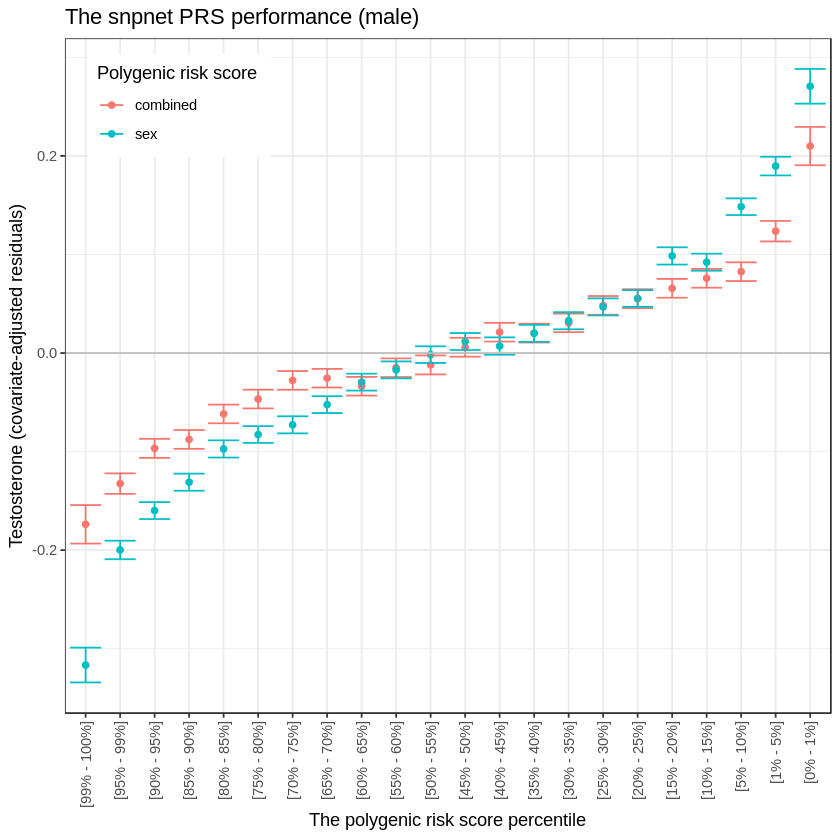

Saving 6.67 x 6.67 in image


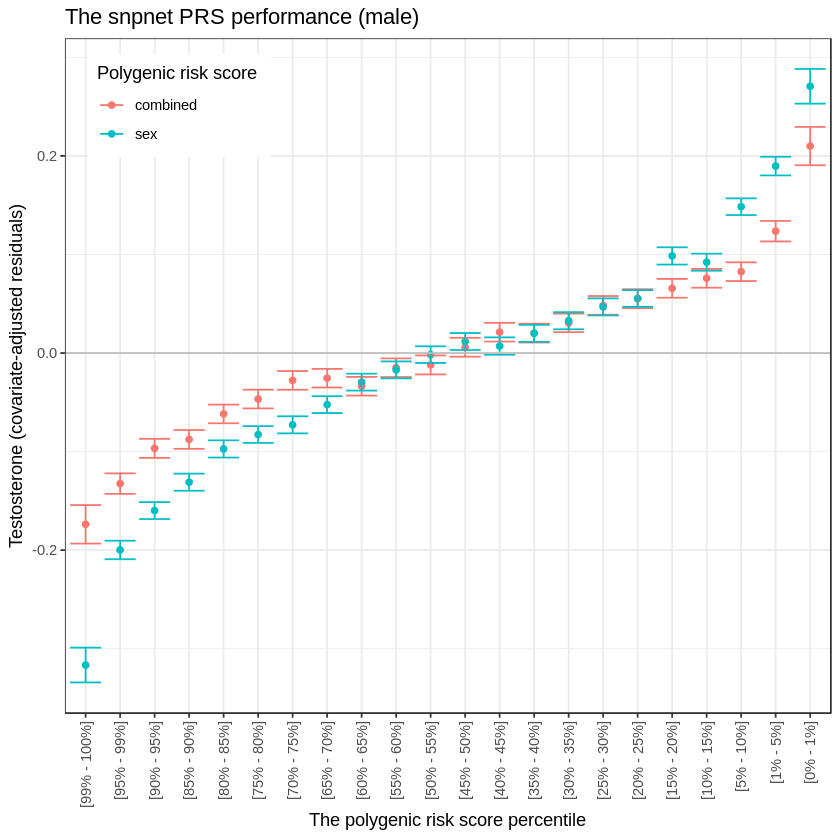

Saving 6.67 x 6.67 in image


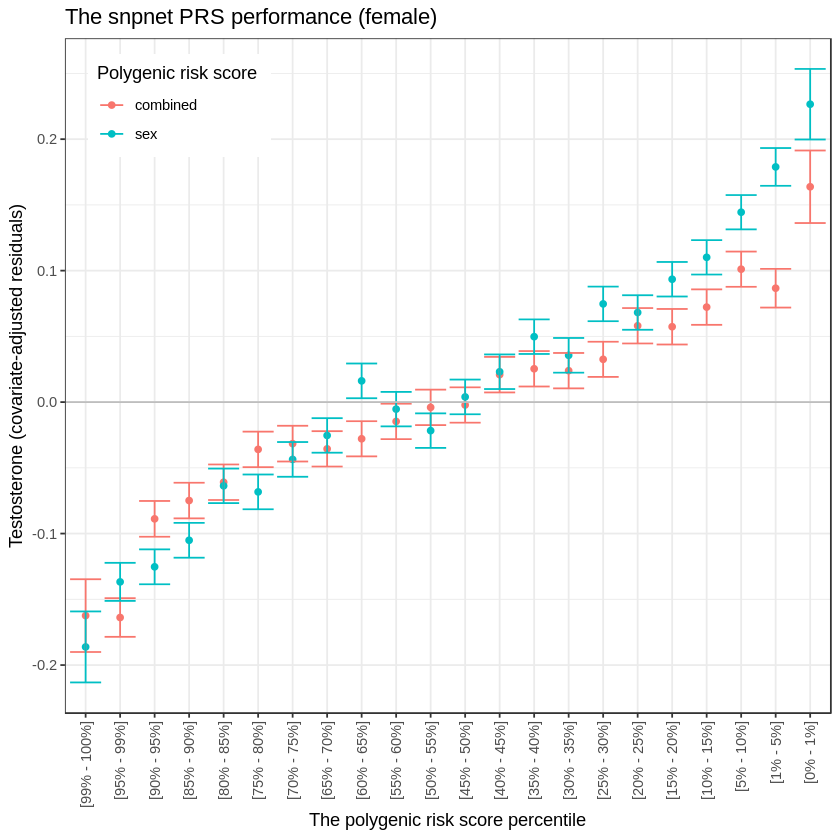

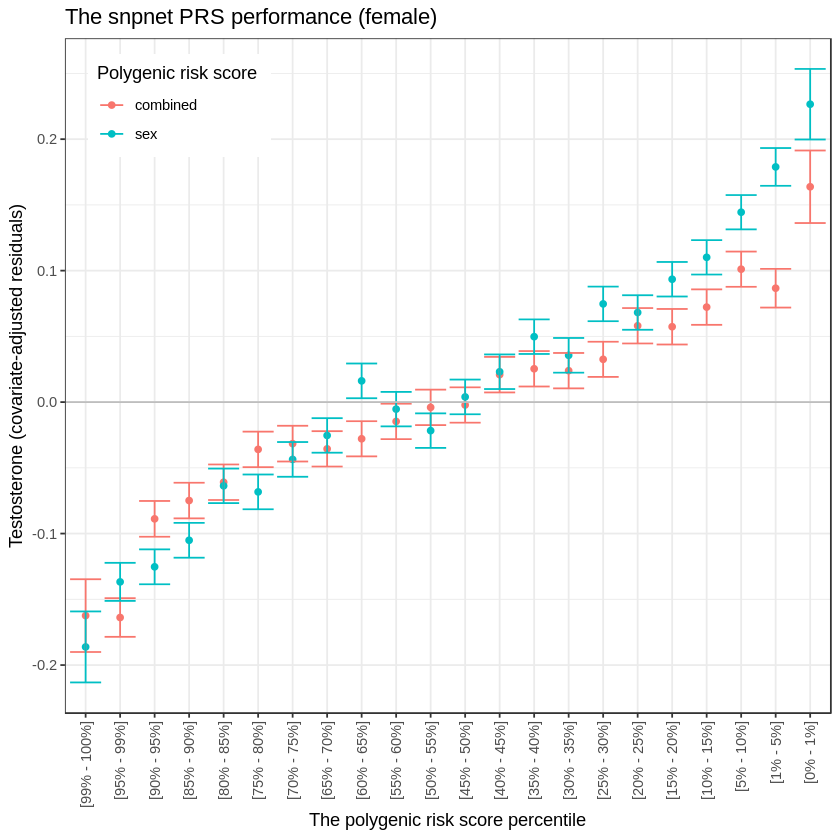

In [55]:
p_male   + ggsave('Testosterone.male.pdf')
p_male   + ggsave('Testosterone.male.png')

p_female + ggsave('Testosterone.female.pdf')
p_female + ggsave('Testosterone.female.png')


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


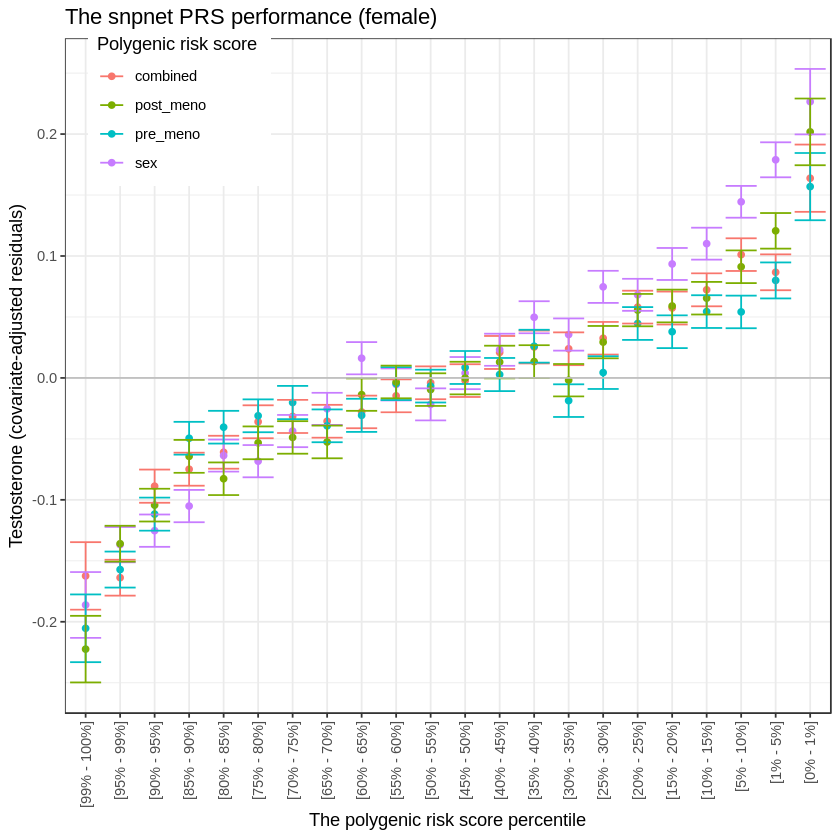

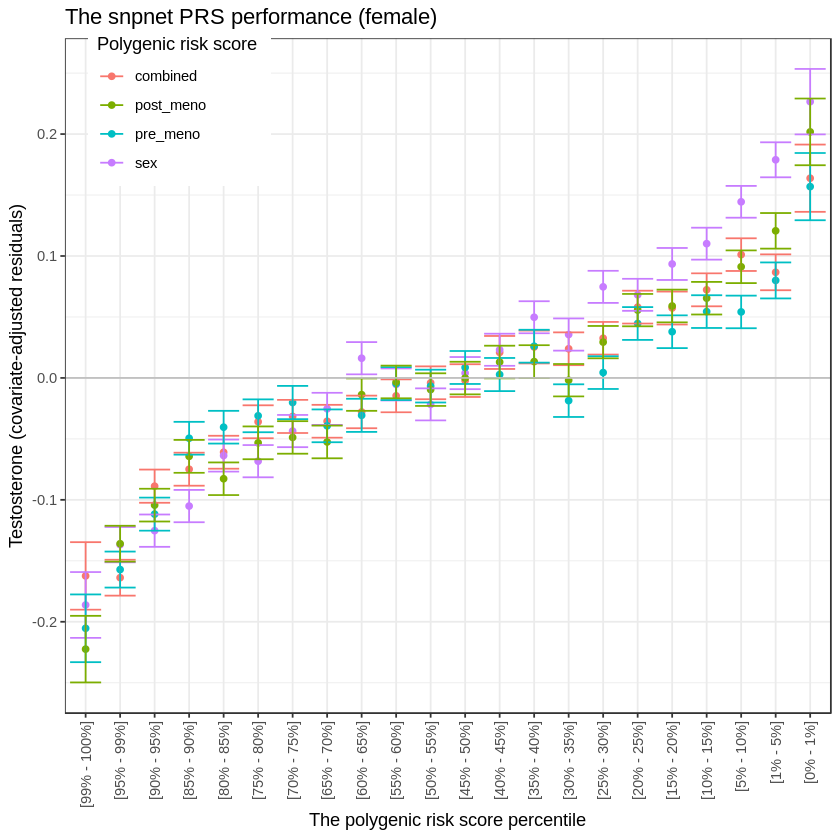

In [62]:
p_female_full + ggsave('Testosterone.female.full.pdf')
p_female_full + ggsave('Testosterone.female.full.png')


In [56]:
cor.test(
    test_df %>% filter(sex == 1) %>% select(male) %>% pull(),
    test_df %>% filter(sex == 1) %>% select(PRS_combined) %>% pull(),
    method = 'spearman'
) %>% print()


Warning message in cor.test.default(test_df %>% filter(sex == 1) %>% select(male) %>% :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  test_df %>% filter(sex == 1) %>% select(male) %>% pull() and test_df %>% filter(sex == 1) %>% select(PRS_combined) %>% pull()
S = 1.6234e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5836842 



In [57]:
p_comp_male <- test_df %>% filter(sex == 1) %>% select(-sex) %>%
rename('sex' = 'male', 'combined' = 'PRS_combined') %>%
mutate(
    sex      = scale(sex,      center = T, scale = T),
    combined = scale(combined, center = T, scale = T),
)%>%
ggplot(aes(
    x = sex, y=combined
)) + 
geom_abline(slope = 1, intercept = 0, color='red', alpha=0.5) +
geom_point(alpha=0.05) + 
theme_bw() + 
theme(legend.position = "none") +
labs(
    title = sprintf('Comparison of PRSs (male)'),
    x = 'Sex-specific PRS', y = 'Combined PRS'
)


In [58]:
cor.test(
    test_df %>% filter(sex == 0) %>% select(female) %>% pull(),
    test_df %>% filter(sex == 0) %>% select(PRS_combined) %>% pull(),
    method = 'spearman'
) %>% print()


Warning message in cor.test.default(test_df %>% filter(sex == 0) %>% select(female) %>% :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  test_df %>% filter(sex == 0) %>% select(female) %>% pull() and test_df %>% filter(sex == 0) %>% select(PRS_combined) %>% pull()
S = 8.587e+12, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6046834 



In [59]:
p_comp_female <- test_df %>% filter(sex == 0) %>% select(-sex) %>%
rename('sex' = 'female', 'combined' = 'PRS_combined') %>%
mutate(
    sex      = scale(sex,      center = T, scale = T),
    combined = scale(combined, center = T, scale = T),
)%>%
ggplot(aes(
    x = sex, y=combined
)) + 
geom_abline(slope = 1, intercept = 0, color='red', alpha=0.5) +
geom_point(alpha=0.05) + 
theme_bw() + 
theme(legend.position = "none") +
labs(
    title = sprintf('Comparison of PRSs (female)'),
    x = 'Sex-specific PRS', y = 'Combined PRS'
)


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


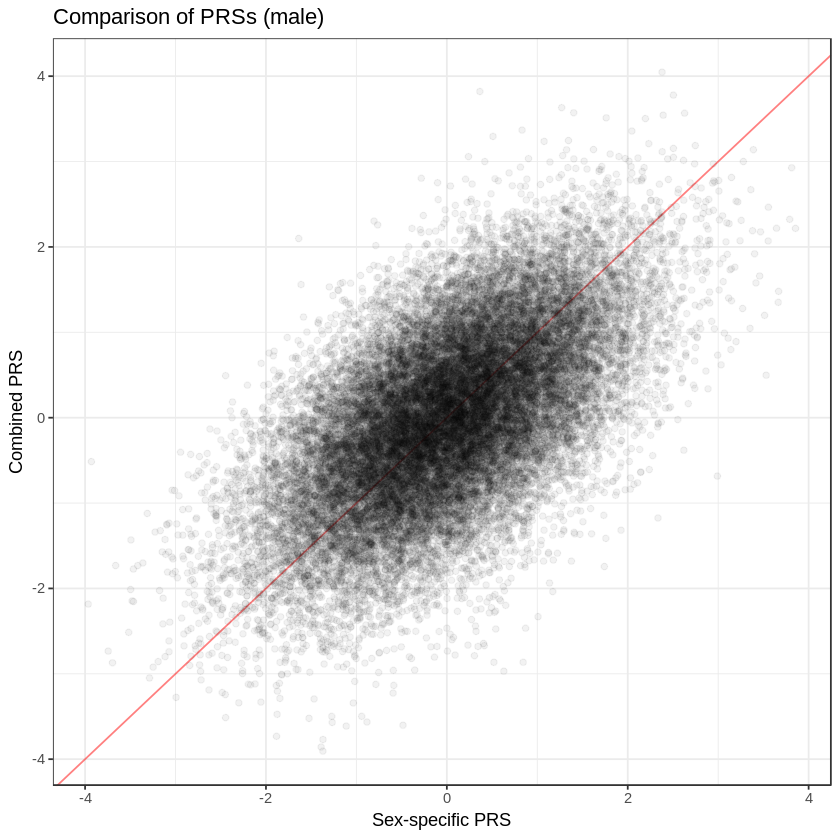

Saving 6.67 x 6.67 in image


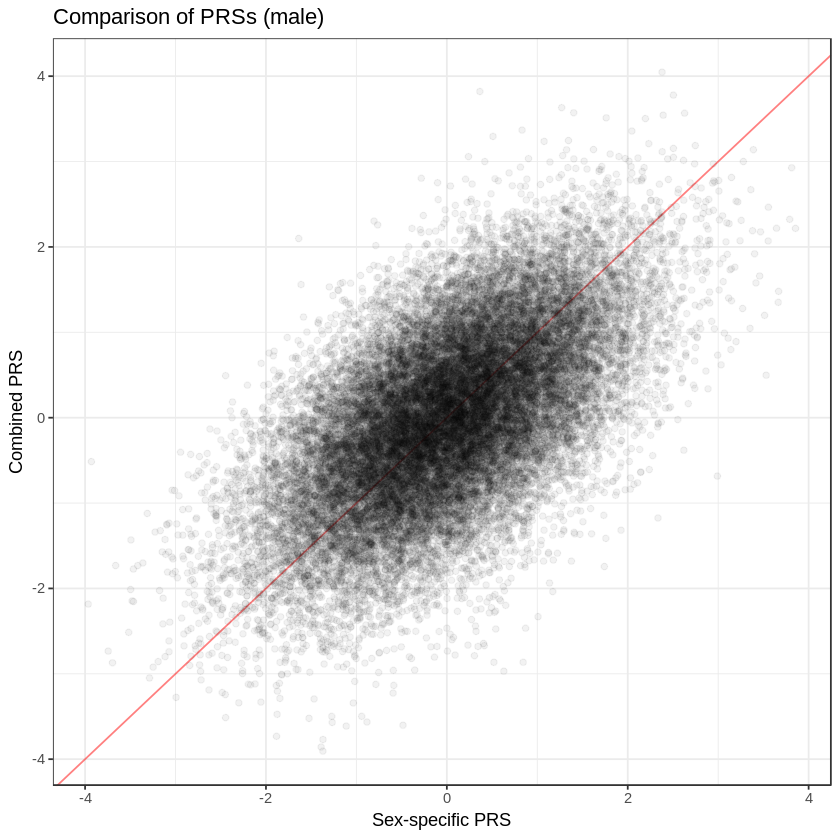

Saving 6.67 x 6.67 in image


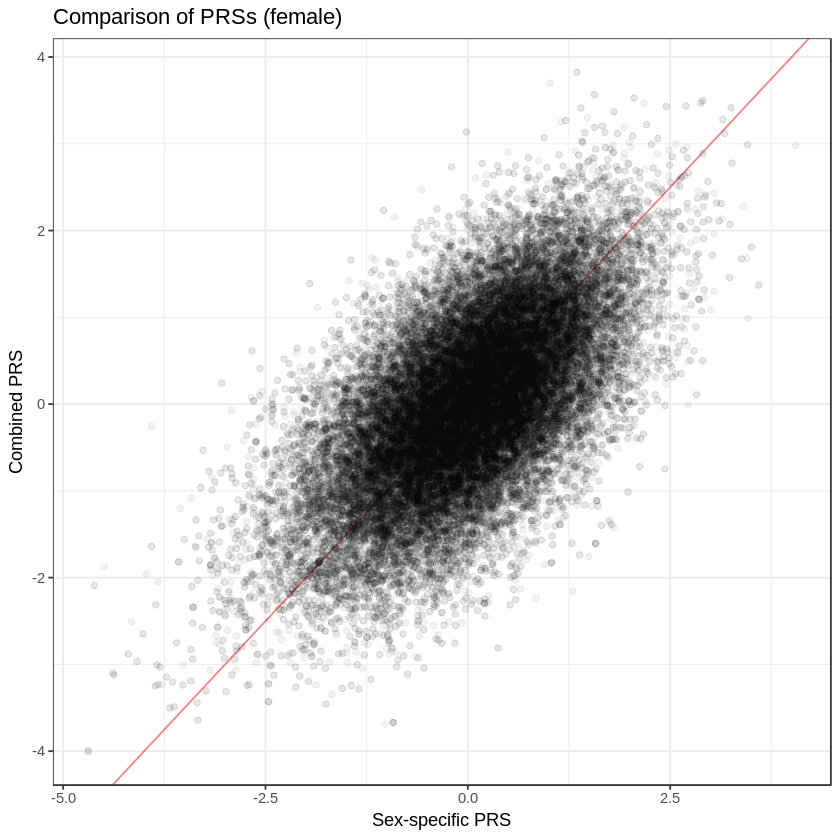

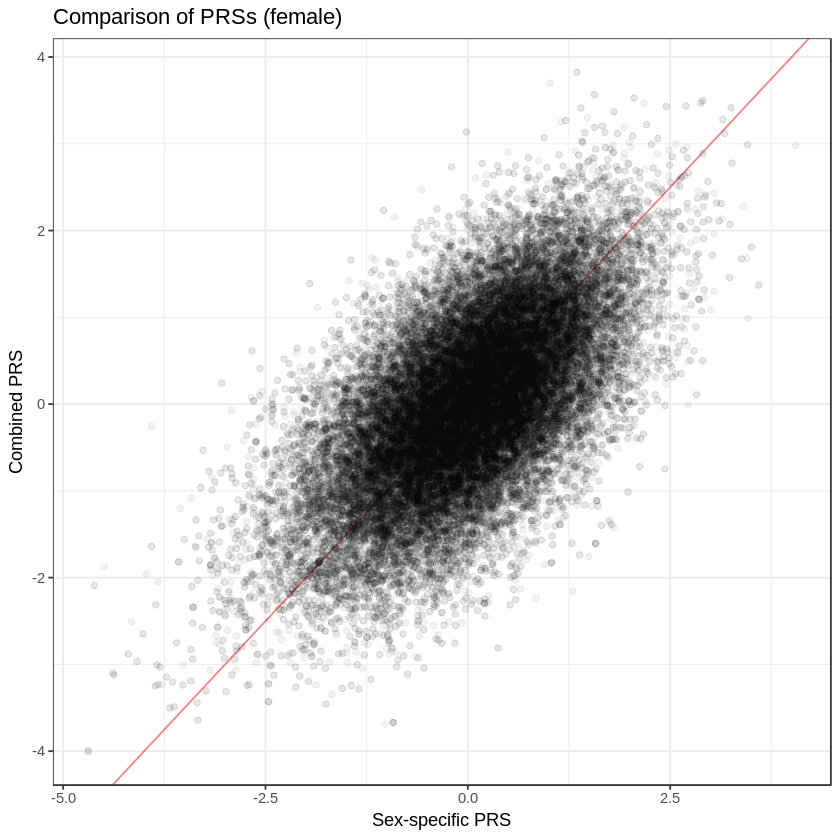

In [60]:
p_comp_male   + ggsave('Testosterone.comp.male.pdf')
p_comp_male   + ggsave('Testosterone.comp.male.png')

p_comp_female + ggsave('Testosterone.comp.female.pdf')
p_comp_female + ggsave('Testosterone.comp.female.png')

